In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from sklearn.cluster import AffinityPropagation
import matplotlib.transforms as transforms


In [3]:
def gen_covariance_2d(eigvals, principal: np.ndarray):
    v1 = principal.reshape((2, 1))
    v2 = np.array([[-v1[1, 0]], [v1[0, 0]]])

    P = np.hstack((v1, v2))
    D = np.diag(eigvals)
    return np.dot(P, np.dot(D, np.linalg.inv(P)))

In [4]:
class Sensor:
    def __init__(self, noise_model):
        self.noise = noise_model
    
    def measure(self, point):
        measurement = np.random.multivariate_normal(point, self.noise, check_valid="raise")
        return (measurement, self.noise)

class BiasedSensor(Sensor):
    def __init__(self, noise_model, bias):
        super(BiasedSensor, self).__init__(noise_model)
        self.bias = np.array(bias)

    def measure(self, point):
        new_point = np.array(point) + self.bias
        return super().measure(new_point)

In [5]:
import itertools

class Agent: # 2d Agent that can only sense
    id_iter = itertools.count()

    def __init__(self, sensors):
        self.sensors = sensors
        self.id = next(self.id_iter)

    def measure(self, point):
        return [sensor.measure(point) for sensor in self.sensors]

class BiasedAgent(Agent):
    def __init__(self, sensors, bias):
        super(BiasedAgent, self).__init__(sensors)
        self.bias = np.array(bias)
    
    def measure(self, point):
        return [(m + self.bias, n) for (m, n) in super().measure(point)]

class OverconfidenceAttacker(BiasedAgent):
    def __init__(self, sensors, overconfidence, bias):
        super(OverconfidenceAttacker, self).__init__(sensors, bias)
        self.overconfidence = overconfidence

    def measure(self, point):
        return [(m + self.bias, self.overconfidence) for (m, _) in super().measure(point)]

class PhantomAttacker(Agent):
    def __init__(self, agents):
        self.id = next(Agent.id_iter)
        self.agents = agents

    def measure(self, point):
        return list(itertools.chain(*[agent.measure(point) for agent in self.agents]))

In [6]:
def gen_data(gt, agents):
    ids = []
    measurements = []
    noises = []
    for agent in agents:
        for (measurement, noise) in agent.measure(gt):
            measurements.append(measurement)
            noises.append(noise)
            ids.append(agent.id)
    return np.array(measurements), np.array(ids), np.array(noises)

In [101]:
def naive_cluster_to_gaussian(measurements, variances, labels): # Naive because we don't consider the covariance matrices
    clusters = []
    for label in np.unique(labels):
        idxs = np.where(labels == label)
        measurement_subset = measurements[idxs]
        variance_subset = variances[idxs]
        if len(measurement_subset) == 1:
            clusters.append((measurement_subset[0], variance_subset[0]))
        else:
            clusters.append((np.mean(measurement_subset, axis=0), np.cov(measurement_subset, rowvar=False)))
    return clusters

def inefficient_cluster_to_gaussian(measurements, variances, labels, n_samples=100): # Inefficient because we just sample
    clusters = []
    for label in np.unique(labels):
        idxs = np.where(labels == label)
        measurement_subset = measurements[idxs]
        variance_subset = variances[idxs]
        if len(measurement_subset) == 1:
            clusters.append((measurement_subset[0], variance_subset[0]))
        else:
            sampled = np.zeros((len(measurement_subset) * n_samples, measurement_subset.shape[1]))
            for (i, (measurement, variance)) in enumerate(zip(measurement_subset, variance_subset)):
                for j in range(n_samples):
                    sampled[n_samples * i + j] = np.random.multivariate_normal(measurement, variance, check_valid="raise")
            clusters.append((np.mean(sampled, axis=0), np.cov(sampled, rowvar=False)))
    return clusters

def canonical_cluster_to_gaussian(measurements, variances, labels): # Uses precision information form
    clusters = []
    for label in np.unique(labels):
        idxs = np.where(labels == label)
        measurement_subset = measurements[idxs]
        variance_subset = variances[idxs]
        if len(measurement_subset) == 1:
            clusters.append((measurement_subset[0], variance_subset[0]))
        else:
            information = np.zeros_like(measurement_subset[0])
            precision = np.zeros_like(variance_subset[0])

            for measurement, variance in zip(measurement_subset, variance_subset):
                p = np.linalg.inv(variance)
                precision += p
                information += np.dot(p, measurement)

            cov = np.linalg.inv(precision)
            mean = np.dot(cov, information)
            

            clusters.append((mean, cov))
    return clusters

In [99]:
def draw_ellipse(ax, mean, cov, n_std):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(*mean)

    ellipse.set_transform(transf + ax.transData)
    return ellipse


def plot_results(data, clusters, summariser="naive"):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    measurements, labels, noises = data

    label_map = {label:i for (i, label) in enumerate(set(labels))}
    plot_cmap = plt.cm.get_cmap("tab10", len(label_map))
    cmap = lambda x: plot_cmap(label_map[x])

    fill_cmap = lambda x: "red" if x == 0 else "blue" if x == 1 else "green"

    for (measurement, label, noise, c) in zip(measurements, labels, noises, clusters):
        ellipse = draw_ellipse(ax, measurement, noise, 1)
        ellipse.set_facecolor(fill_cmap(c))
        ellipse.set_facecolor("none")
        ellipse.set_edgecolor(cmap(label))
        ax.add_patch(ellipse)

    if summariser == "naive":
        cluster_summaries = naive_cluster_to_gaussian(measurements, noises, clusters)
    elif summariser == "samples":
        cluster_summaries = inefficient_cluster_to_gaussian(measurements, noises, clusters, 100)
    elif summariser == "canonical":
        cluster_summaries = canonical_cluster_to_gaussian(measurements, noises, clusters)

    for (centre, variance) in cluster_summaries:
        for i in range(1, 4):
            ellipse = draw_ellipse(ax, centre, variance, i)
            ellipse.set_facecolor("red")
            ellipse.set_alpha(0.2)
            ax.add_patch(ellipse)

    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.scatter(measurements[:, 0], measurements[:, 1], marker="")

In [9]:
def compute_distance_matrix(data, dist_func):
    matrix = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            dist = dist_func(data[i], data[j])
            matrix[i, j] = dist
            matrix[j, i] = dist
    return matrix

euclidean = lambda x, y: np.linalg.norm(x[:2] - y[:2]) # Naive because it ignores the variances

# Limited Antifragility
Sometimes attacks actually make the robot *more* robust to them.

See the code below.

I'm not sure if this is normal behaviour or a weird side effect of how I'm combining gaussians, measuring distances and the AffinityPropagation algorithm

[0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


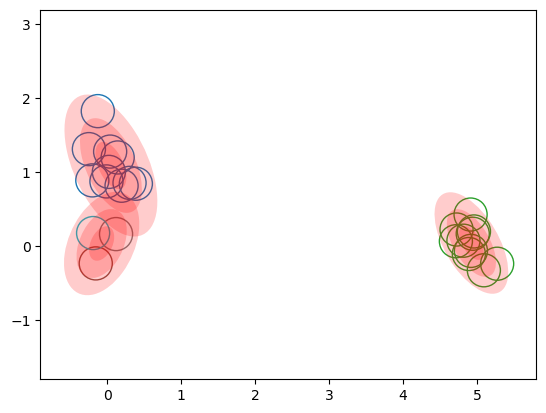

In [97]:
default = Sensor(np.diag([0.05, 0.05]))

data = gen_data((0, 0), [
    Agent([default]),
    Agent([default]),
    Agent([default]),
    PhantomAttacker([BiasedAgent([default], [0, 1]) for _ in range(10)]),
    PhantomAttacker([BiasedAgent([default], [5, 0]) for _ in range(10)]),
    # Uncomment the other 2 to stop this effect
    # PhantomAttacker([BiasedAgent([default], [5, 1]) for _ in range(10)]),
    # PhantomAttacker([BiasedAgent([default], [-5, 0]) for _ in range(10)]),
])

dist = compute_distance_matrix(data[0], euclidean)

model = AffinityPropagation(affinity="precomputed")

model.fit(-dist)

clusters = model.labels_
print(clusters)

plot_results(data, clusters)

[0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


TypeError: canonical_cluster_to_gaussian() takes 3 positional arguments but 4 were given

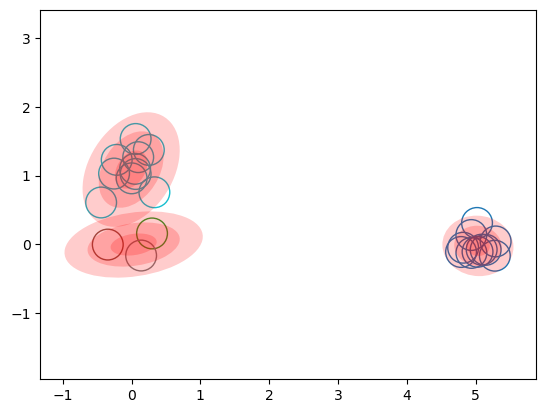

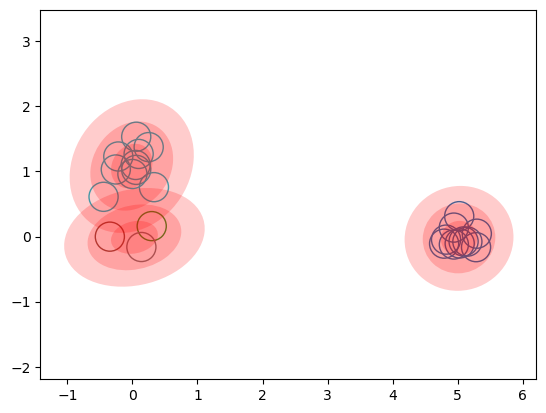

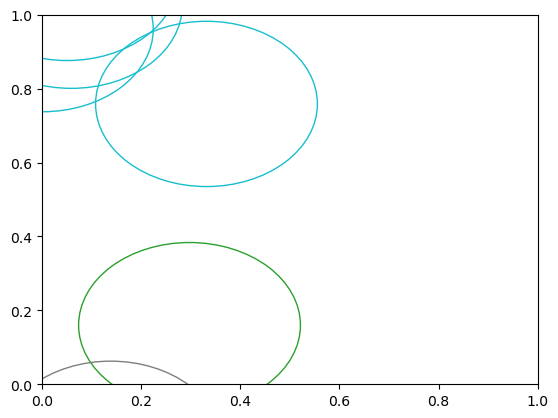

In [102]:
np.random.seed(10)
default = Sensor(np.diag([0.05, 0.05]))

data = gen_data((0, 0), [
    Agent([default]),
    Agent([default]),
    Agent([default]),
    PhantomAttacker([BiasedAgent([default], [0, 1]) for _ in range(10)]),
    PhantomAttacker([BiasedAgent([default], [5, 0]) for _ in range(10)]),
    # Uncomment the other 2 to stop this effect
    # PhantomAttacker([BiasedAgent([default], [5, 1]) for _ in range(10)]),
    # PhantomAttacker([BiasedAgent([default], [-5, 0]) for _ in range(10)]),
])

dist = compute_distance_matrix(data[0], euclidean)

model = AffinityPropagation(affinity="precomputed")

model.fit(-dist)

clusters = model.labels_
print(clusters)

plot_results(data, clusters)
plot_results(data, clusters, summariser="samples")
plot_results(data, clusters, summariser="canonical")